In [1]:
#My Packages
from architectures.RNET import RNET7, RNET6, RNET5, RNET3
from architectures.UNET import UNET
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, Callback, LearningRateScheduler
from tensorflow.keras.initializers import TruncatedNormal, glorot_uniform
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as pltsplit_into_patchessplit_into_patches
from utils.data import load_hera_pickle, load_lofar_pickle, split_into_patches, normalize_patches
from architectures.RFDL import RFDL_RNET7, SIMPLE_UNET

In [2]:
def Conv2D_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True, stride=(1,1)):
    # first layer
    x = layers.Conv2D(filters = n_filters, 
                      kernel_size = (kernel_size, kernel_size),\
                      kernel_initializer = 'he_normal', 
                      strides=stride,
                      padding = 'same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    return x

def corrupt_images(images):
    corrupted_images = images.copy()
    img_height, img_width = images.shape[1:3]

    for i in range(images.shape[0]):
        
        for _ in range(np.random.randint(0, 4)):
            brightness_factor = np.random.uniform(0.05, 0.20)
            orientation = np.random.choice(['horizontal', 'vertical'])
            line_width = np.random.randint(1, 4)

            if orientation == 'horizontal':
                x = np.random.randint(0, img_width - line_width + 1)
                corrupted_images[i, x:x+line_width, :, :] += brightness_factor
            else:
                y = np.random.randint(0, img_height - line_width + 1)
                corrupted_images[i, :, y:y+line_width, :] += brightness_factor

        # Add 0 to 3 dashed lines of corruption
        for _ in range(np.random.randint(1, 10)):
            brightness_factor = np.random.uniform(0.10, 0.50)
            orientation = np.random.choice(['horizontal', 'vertical'])
            line_width = np.random.randint(1, 2)
            dash_length = np.random.randint(1, img_width/2 + 1)
            gap_length = np.random.randint(1, img_width/4 + 1)
            if orientation == 'horizontal':
                x = np.random.randint(0, img_width - line_width + 1)
                y = 0
                while y < img_height:
                    corrupted_images[i, x:x+line_width, y:y+dash_length, :] += brightness_factor
                    y += dash_length + gap_length
            else:
                x = 0
                y = np.random.randint(0, img_height - line_width + 1)
                while x < img_width:
                    corrupted_images[i, x:x+dash_length, y:y+line_width, :] += brightness_factor
                    x += dash_length + gap_length

        # Add 0 to 3 small blocks of corruption
        for _ in range(np.random.randint(1, 3)):
            brightness_factor = np.random.uniform(0.10, 0.50)
            block_size = np.random.randint(2, 5)
            x = np.random.randint(0, img_width - block_size + 1)
            y = np.random.randint(0, img_height - block_size + 1)
            corrupted_images[i, x:x+block_size, y:y+block_size, :] += brightness_factor

    
    corruption_mask = corrupted_images - images

    # Identify the pixels to corrupt further with Gaussian noise
    to_corrupt = corruption_mask > 0

    # Generate Gaussian noise
    noise = np.random.normal(0, 0.1, corrupted_images.shape)

    # Apply the Gaussian noise only to the pixels identified by the corruption mask
    corrupted_images[to_corrupt] += noise[to_corrupt]

    # Ensure pixel values remain in the valid range [0, 1]
    corrupted_images = np.clip(corrupted_images, 0, 1)

    return corrupted_images

def gaussian_noise(data):
    mean = 0
    var = 10
    sigma = var**0.5
    noise = np.random.normal(mean, sigma, data.shape)
    noisy_data = np.clip(data + noise, 0, 1)  # Clip values to be in valid range
    return noisy_data

def flip(data, flip_type):
    if flip_type == 0:
        return np.flip(data, axis=1)  # Vertical flip
    elif flip_type == 1:
        return np.flip(data, axis=2)  # Horizontal flip
    elif flip_type == 2:
        return np.flip(np.flip(data, axis=1), axis=2)  # Both flips

def rotate(data, k):
    return np.rot90(data, k=k, axes=(1, 2))

def augment(data, mask):
    augmented_data = []
    augmented_masks = []

    for flip_type in range(3):  # 0: vertical, 1: horizontal, 2: both
        data_flipped = flip(data, flip_type)
        mask_flipped = flip(mask, flip_type)
        
        for k in range(4):  # 0: 0 degrees, 1: 90 degrees, 2: 180 degrees, 3: 270 degrees
            data_rotated = rotate(data_flipped, k)
            mask_rotated = rotate(mask_flipped, k)
            
            augmented_data.append(data_rotated)
            augmented_masks.append(mask_rotated)
    
    # Adding Gaussian noise to the augmented data
    # noisy_data = gaussian_noise(np.concatenate(augmented_data, axis=0))
    
    # Concatenating the noisy data with the original augmented data
    augmented_data = np.concatenate(augmented_data, axis=0)
    
    # Repeating the masks for the noisy data
    augmented_masks = np.concatenate(augmented_masks, axis=0)
    
    return augmented_data, augmented_masks

In [3]:
batch_sz = 64
data_path = "LOFAR"

#Load Training Data
X_train, y_train, X_test, y_test = load_lofar_pickle("../../data/HERA-SIM_Full_RFI_dataset.pkl", limit=1500)
y_train = y_train[:, :, :, np.newaxis]
print(y_train.shape)
X_train = (split_into_patches(X_train, batch_sz))
y_train = split_into_patches(y_train, batch_sz)
X_test = (split_into_patches(X_test, batch_sz))
y_test = split_into_patches(y_test, batch_sz)

normal_patches = np.where(np.all(y_train == 0, axis=(1,2,3)))[0]
X_train_normal = X_train[normal_patches]
X_train_normal = np.concatenate((X_train_normal, flip(X_train_normal,1)), axis=0)

X_train_corrupted = corrupt_images(X_train_normal)

X_noise = (X_train_corrupted - X_train_normal) > 0
y_train_combined = np.concatenate([X_train_normal, X_noise], axis=-1)

LOADING LOFAR DATASET FROM ../../data/HERA-SIM_Full_RFI_dataset.pkl
SUCCESS
PREPROCESSING...
PREPROCESSING COMPLETE
(960, 512, 512, 1)


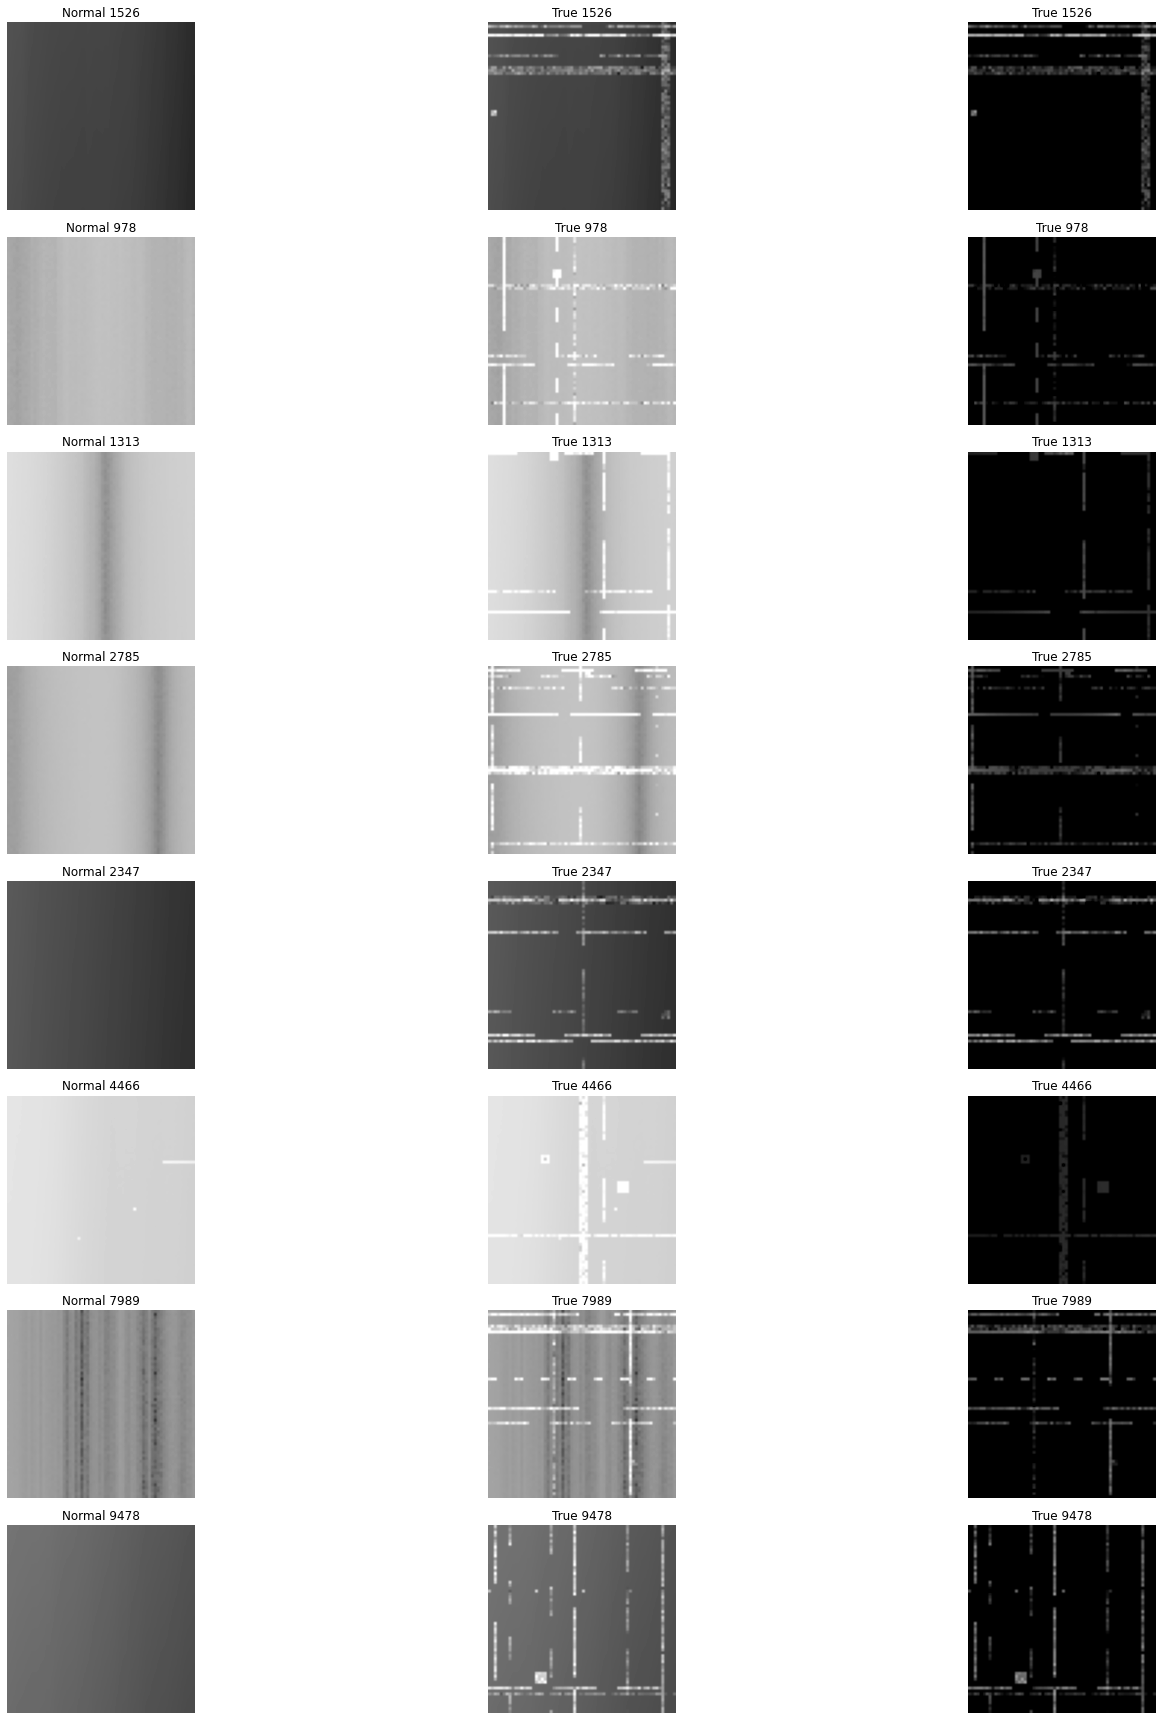

In [4]:
# Shuffle the indices to get a random sample of images
shuffled_indices = np.random.permutation(len(X_train_normal))[:8]

# Plot the actual, corrupted, and inpainted images side by side
fig, axes = plt.subplots(8, 3, figsize=(24, 24))

# Adjust the margins between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i, idx in enumerate(shuffled_indices):
    # Plot the actual image
    axes[i, 0].imshow(X_train_normal[idx].reshape(batch_sz, batch_sz), cmap='gray', vmin=0, vmax=1)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Normal {idx}')
    
    # Plot the actual image
    axes[i, 1].imshow(X_train_corrupted[idx].reshape(batch_sz, batch_sz), cmap='gray', vmin=0, vmax=1)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'True {idx}')
    
    # Plot the actual image
    axes[i, 2].imshow((X_train_corrupted[idx] - X_train_normal[idx]).reshape(batch_sz, batch_sz), cmap='gray', vmin=0, vmax=1)
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f'True {idx}')

plt.tight_layout()
plt.show()

In [5]:
unet = SIMPLE_UNET((64,64,1))
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
unet.fit(X_train_corrupted, y_train_combined, epochs=200, batch_size=128, validation_split=0.2, verbose=1, callbacks=[checkpoint])
unet.save('RFDL_UNET_SIMPLE_HERA.h5')

2023-10-16 10:28:39.433835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 10:28:39.437080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 10:28:39.437198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 10:28:39.437665: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/200


2023-10-16 10:28:40.785587: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2023-10-16 10:28:41.062426: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-16 10:28:41.062743: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-16 10:28:41.062762: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2023-10-16 10:28:41.063114: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-16 10:28:41.063167: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


62/62 [==============================] - 5s 50ms/step - loss: 0.3152 - val_loss: 0.0136

Epoch 00001: val_loss improved from inf to 0.01364, saving model to best_model.h5
Epoch 2/200
 5/62 [=>............................] - ETA: 1s - loss: 0.0159

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


62/62 [==============================] - 2s 35ms/step - loss: 0.0112 - val_loss: 0.0040

Epoch 00002: val_loss improved from 0.01364 to 0.00396, saving model to best_model.h5
Epoch 3/200
62/62 [==============================] - 2s 35ms/step - loss: 0.0089 - val_loss: 0.0034

Epoch 00003: val_loss improved from 0.00396 to 0.00339, saving model to best_model.h5
Epoch 4/200
62/62 [==============================] - 2s 35ms/step - loss: 0.0063 - val_loss: 0.0026

Epoch 00004: val_loss improved from 0.00339 to 0.00265, saving model to best_model.h5
Epoch 5/200
62/62 [==============================] - 2s 35ms/step - loss: 0.0053 - val_loss: 0.0043

Epoch 00005: val_loss did not improve from 0.00265
Epoch 6/200
62/62 [==============================] - 2s 35ms/step - loss: 0.0046 - val_loss: 0.0040

Epoch 00006: val_loss did not improve from 0.00265
Epoch 7/200
62/62 [==============================] - 2s 35ms/step - loss: 0.0040 - val_loss: 0.0031

Epoch 00007: val_loss did not improve from 0.0

In [6]:
# unet = load_model("RFDL_UNET.h5", custom_objects={'weighted_mse': weighted_mse})

X_test_inpainted = unet.predict(X_test)

from scipy.ndimage import gaussian_filter
import numpy as np

def smooth_images(images):
    smoothed_images = np.empty_like(images)
    
    for i in range(images.shape[0]):
        smoothed_images[i] = gaussian_filter(images[i], sigma=1)
    
    return smoothed_images

# X_test_inpainted = smooth_images(X_test_inpainted)

X_diff = X_test - X_test_inpainted

Average MSE: 0.0014953563222661614


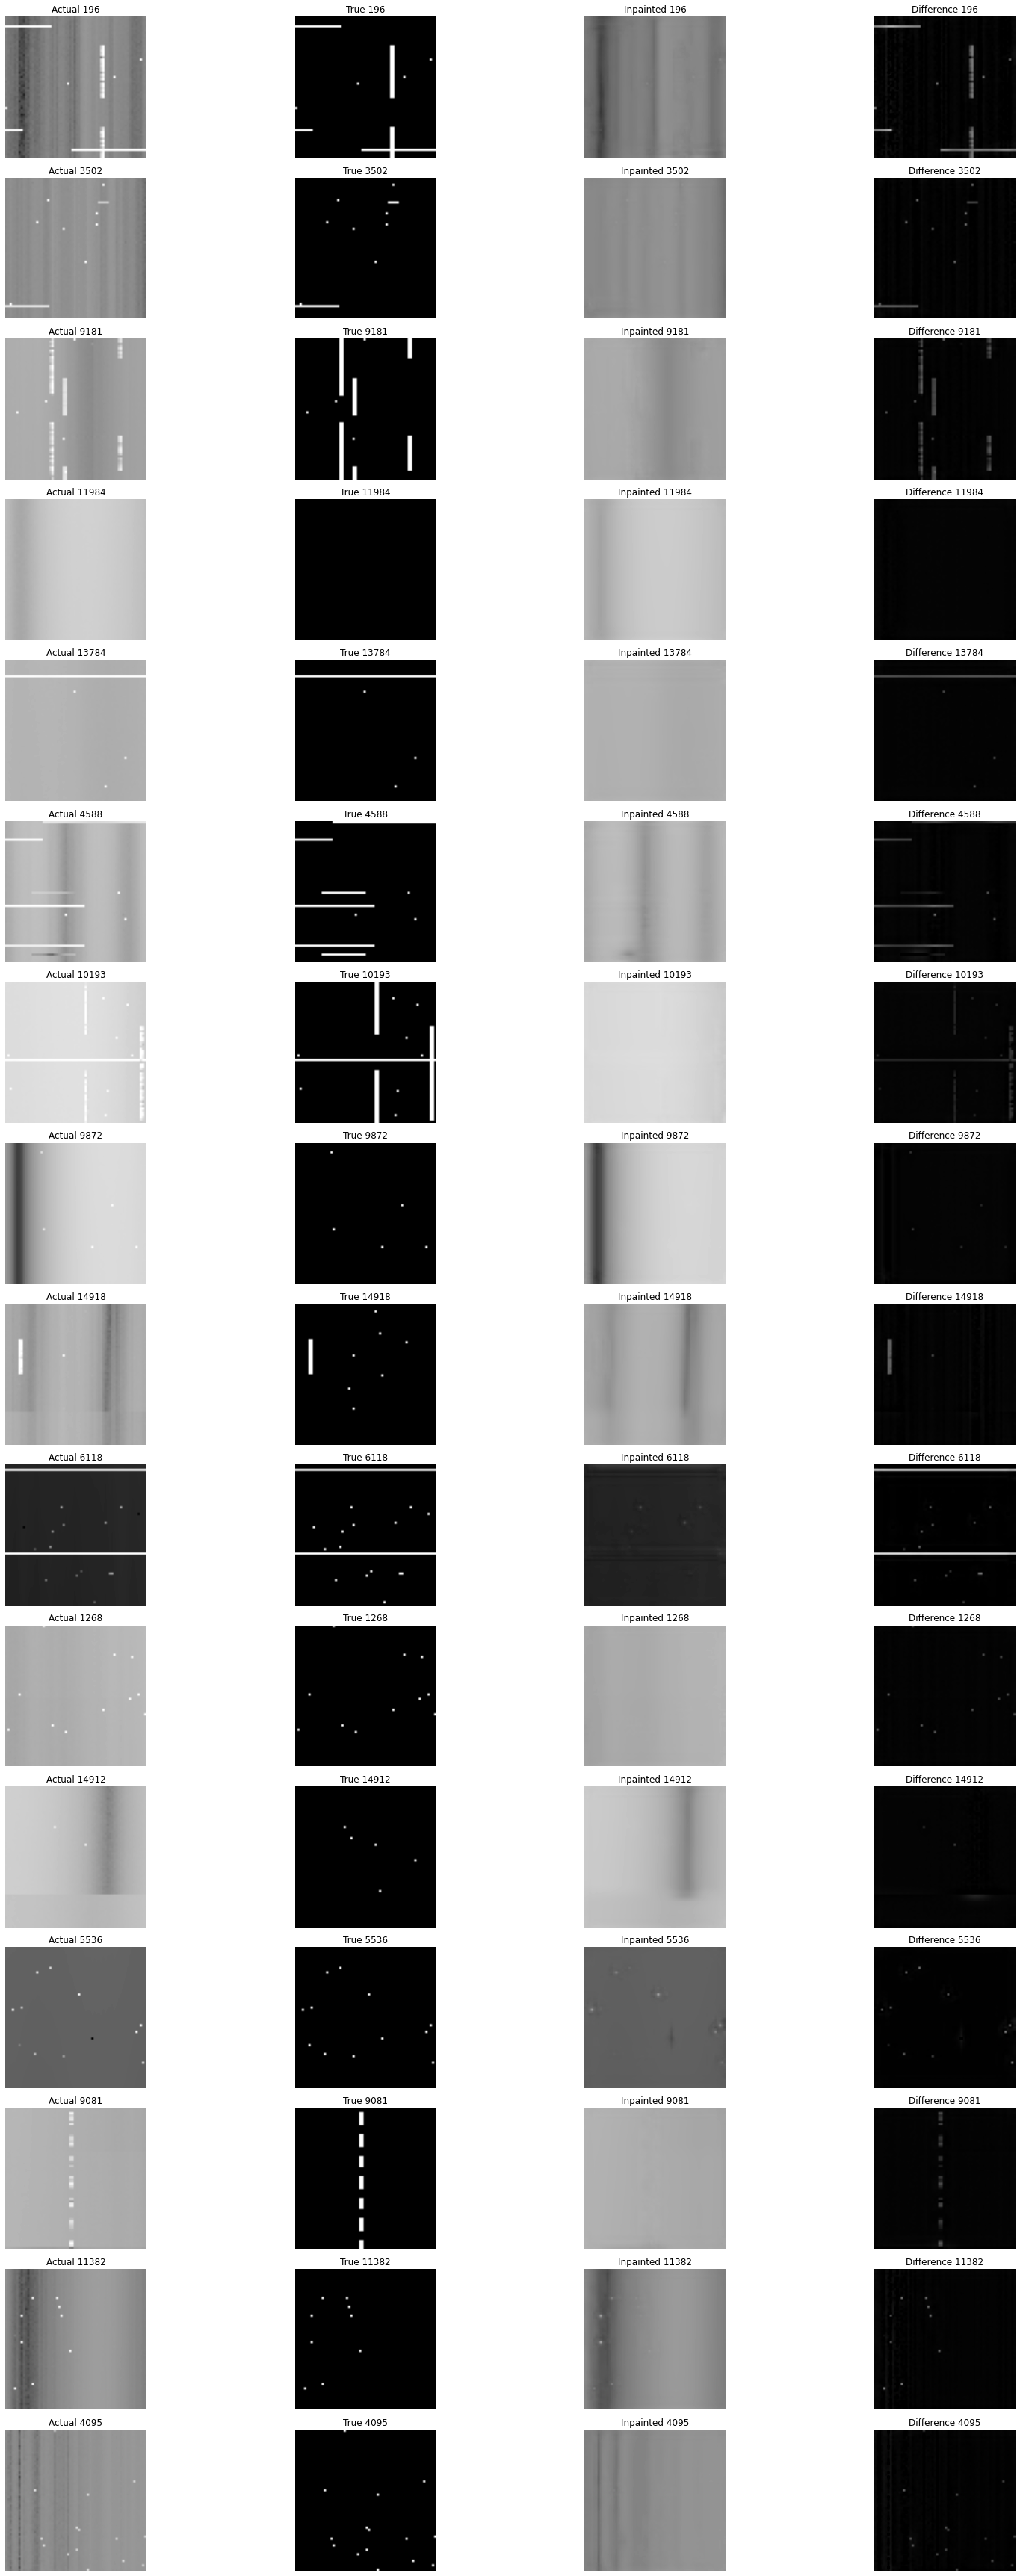

In [7]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Calculate the MSE for each image in the test set
mse_values = [mean_squared_error(X_test[i].flatten(), X_test_inpainted[i].flatten()) for i in range(len(X_test))]

# Calculate the average MSE across all test images
average_mse = np.mean(mse_values)
print(f"Average MSE: {average_mse}")

# Shuffle the indices to get a random sample of images
shuffled_indices = np.random.permutation(len(X_test))[:16]

# Plot the actual, corrupted, and inpainted images side by side
fig, axes = plt.subplots(16, 4, figsize=(24, 48))

# Adjust the margins between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i, idx in enumerate(shuffled_indices):
    # Plot the actual image
    axes[i, 0].imshow(X_test[idx].reshape(batch_sz, batch_sz), cmap='gray', vmin=0, vmax=1)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Actual {idx}')
    
    # Plot the actual image
    axes[i, 1].imshow(y_test[idx].reshape(batch_sz, batch_sz), cmap='gray', vmin=0, vmax=1)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'True {idx}')
    
    # Plot the inpainted image
    axes[i, 2].imshow(X_test_inpainted[idx].reshape(batch_sz, batch_sz), cmap='gray', vmin=0, vmax=1)
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f'Inpainted {idx}')
    
    # Plot the inpainted image
    axes[i, 3].imshow(X_diff[idx].reshape(batch_sz, batch_sz), cmap='gray', vmin=0, vmax=1)
    axes[i, 3].axis('off')
    axes[i, 3].set_title(f'Difference {idx}')

plt.tight_layout()

Best Threshold=0.095584, F-Score=0.858


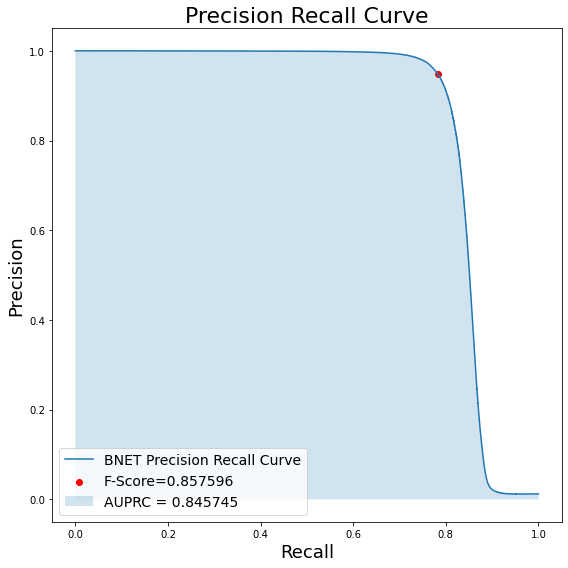

In [8]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay, f1_score
from numpy import argmax

y_prob_flat = X_diff.reshape(-1,1)
y_true_flat = y_test.reshape(-1,1)

plt.figure(figsize=(8, 8))  # Adjust the figure size

precision, recall, thresholds = precision_recall_curve(y_true_flat, y_prob_flat)
auc_precision_recall = auc(recall, precision)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall + 1e-22)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

plt.plot(recall, precision, label='BNET Precision Recall Curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='red', label='F-Score={0:.6f}'.format(fscore[ix]))
plt.fill_between(recall, precision, alpha=0.2, label="AUPRC = {0:.6f}".format(auc_precision_recall))
plt.title("Precision Recall Curve", fontsize=22)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()